In [1]:
import os 
import sys 
import h5py 
import numpy as np 
import corner as DFM 
# -- galpopfm --
from galpopfm.catalogs import Catalog
from galpopfm import dust_infer as dustInfer
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']
abc_dir = os.path.join(dat_dir, 'abc', 'eagle.slab_noll_mssfr_fixbump.L2_only.3d') 
T = 22

In [3]:
#########################################################################
# read in SDSS measurements
#########################################################################
r_edges, gr_edges, fn_edges, _ = dustInfer.sumstat_obs(statistic='2d',
        return_bins=True)
dr  = r_edges[1] - r_edges[0]
dgr = gr_edges[1] - gr_edges[0]
dfn = fn_edges[1] - fn_edges[0]
ranges = [(r_edges[0], r_edges[-1]), (-0.05, 1.7), (-1., 4.)]

sdss = Catalog('tinker') 
sdss_M_fuv, sdss_M_nuv, _, sdss_M_g, sdss_M_r, _, _ = sdss.data['NSA_ABSMAG'].T
mr_complete = (sdss_M_r < -20.) 

x_obs = [-1.*sdss_M_r[mr_complete], 
        sdss_M_g[mr_complete] - sdss_M_r[mr_complete], 
        sdss_M_fuv[mr_complete] - sdss_M_nuv[mr_complete]] 

In [4]:
theta_T = np.loadtxt(os.path.join(abc_dir, 'theta.t%i.dat' % T)) 
rho_T   = np.loadtxt(os.path.join(abc_dir, 'rho.t%i.dat' % T)) 
w_T     = np.loadtxt(os.path.join(abc_dir, 'w.t%i.dat' % T)) 
theta_med = np.median(theta_T, axis=0) 

In [5]:
####################################################################################
# read simulations 
####################################################################################
_sim_sed = dustInfer._read_sed('eagle') 
wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
cuts = (_sim_sed['logmstar'] > 9.4)
sfr0 = (_sim_sed['logsfr.inst'][cuts] == -999)

sim_sed = {} 
sim_sed['sim']          = 'eagle'
sim_sed['logmstar']     = _sim_sed['logmstar'][cuts].copy()
sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cuts].copy() 
sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cuts,:][:,wlim].copy() 
sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 
print('%i SFR=0 galaxies' % np.sum(sfr0))
print('out of %i galaxies' % np.sum(cuts))

1490 SFR=0 galaxies
out of 8294 galaxies


In [6]:
fm_nodust = dustInfer.sumstat_model(np.zeros(6), sed=sim_sed, dem='slab_noll_mssfr_fixbump',
                          statistic='2d', sfr0_prescription='sfrmin', return_datavector=True)

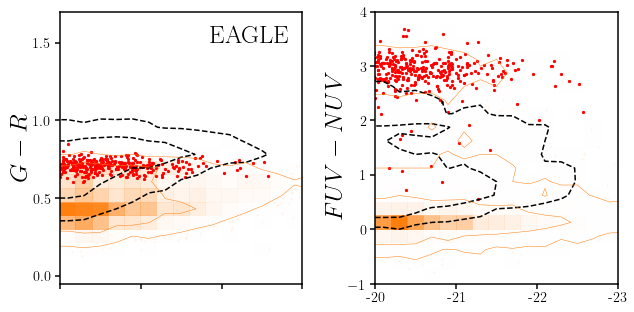

In [7]:
fig = plt.figure(figsize=(10,5))
# R vs (G - R)
sub = fig.add_subplot(121)
DFM.hist2d(x_obs[0], x_obs[1], levels=[0.68, 0.95],
        range=[ranges[0], ranges[1]], bins=20, color='k', 
        contour_kwargs={'linestyles': 'dashed'}, 
        plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
DFM.hist2d(fm_nodust[0], fm_nodust[1], levels=[0.68, 0.95],
        range=[ranges[0], ranges[1]], bins=20, color='C1', 
        contour_kwargs={'linewidths': 0.5}, 
        plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
sub.scatter(fm_nodust[0][sfr0], fm_nodust[1][sfr0], c='r', s=5)
sub.text(0.95, 0.95, 'EAGLE', ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylabel(r'$G-R$', fontsize=25) 
sub.set_ylim(ranges[1]) 
sub.set_yticks([0., 0.5, 1., 1.5])

# R vs FUV-NUV
sub = fig.add_subplot(122)
DFM.hist2d(x_obs[0], x_obs[2], levels=[0.68, 0.95],
        range=[ranges[0], ranges[2]], bins=20, color='k', 
        contour_kwargs={'linestyles': 'dashed'}, 
        plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
DFM.hist2d(fm_nodust[0], fm_nodust[2], levels=[0.68, 0.95],
        range=[ranges[0], ranges[2]], bins=20, color='C1', 
        contour_kwargs={'linewidths': 0.5}, 
        plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
sub.scatter(fm_nodust[0][sfr0], fm_nodust[2][sfr0], c='r', s=5)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=25) 
sub.set_ylim(ranges[2]) 
fig.subplots_adjust(wspace=0.3)

In [8]:
fm_med = dustInfer.sumstat_model(theta_med, sed=sim_sed, dem='slab_noll_mssfr_fixbump',
                                 statistic='2d', sfr0_prescription='sfrmin', return_datavector=True)

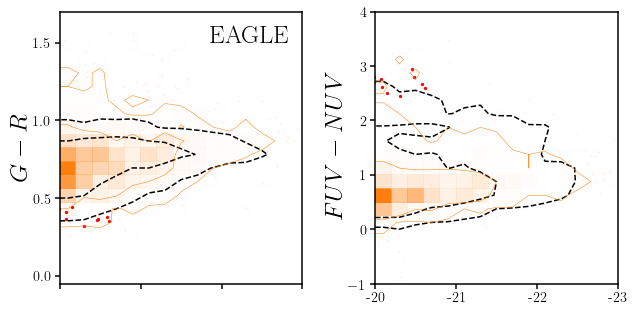

In [9]:
fig = plt.figure(figsize=(10,5))
# R vs (G - R)
sub = fig.add_subplot(121)
DFM.hist2d(x_obs[0], x_obs[1], levels=[0.68, 0.95],
        range=[ranges[0], ranges[1]], bins=20, color='k', 
        contour_kwargs={'linestyles': 'dashed'}, 
        plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
DFM.hist2d(fm_med[0], fm_med[1], levels=[0.68, 0.95],
        range=[ranges[0], ranges[1]], bins=20, color='C1', 
        contour_kwargs={'linewidths': 0.5}, 
        plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
sub.scatter(fm_med[0][sfr0], fm_med[1][sfr0], c='r', s=5)
sub.text(0.95, 0.95, 'EAGLE', ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylabel(r'$G-R$', fontsize=25) 
sub.set_ylim(ranges[1]) 
sub.set_yticks([0., 0.5, 1., 1.5])

# R vs FUV-NUV
sub = fig.add_subplot(122)
DFM.hist2d(x_obs[0], x_obs[2], levels=[0.68, 0.95],
        range=[ranges[0], ranges[2]], bins=20, color='k', 
        contour_kwargs={'linestyles': 'dashed'}, 
        plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
DFM.hist2d(fm_med[0], fm_med[2], levels=[0.68, 0.95],
        range=[ranges[0], ranges[2]], bins=20, color='C1', 
        contour_kwargs={'linewidths': 0.5}, 
        plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
sub.scatter(fm_med[0][sfr0], fm_med[2][sfr0], c='r', s=5)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=25) 
sub.set_ylim(ranges[2]) 
fig.subplots_adjust(wspace=0.3)

In [10]:
theta_med

array([ 0.05109417, -0.98138598,  1.04235017, -0.35981393, -0.60214979,
       -0.30254883])

In [11]:
x_obs = dustInfer.sumstat_obs(statistic='3d')

In [17]:
x_mod = dustInfer.sumstat_model(theta_med, sed=sim_sed, dem='slab_noll_mssfr_fixbump', statistic='3d', noise=True, sfr0_prescription='sfrmin')

In [18]:
dustInfer.distance_metric(x_obs, x_mod, method='L2')[1]

     (1.216852168000047e-05, 0.0034971098239076335)


0.0034971098239076335